<a href="https://colab.research.google.com/github/tkhan3/machinelearning/blob/master/HR_Analytics_15000_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
#import pandas as pd
!google-drive-ocamlfuse drive
!apt-get -qq install -y graphviz && pip install -q pydot
!pip3 install seaborn==0.9.0
import pydot
!mkdir -p drive
!google-drive-ocamlfuse drive
!pip install sklearn_pandas

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110851 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

**Objective of this study is to build a proactive system that will help in predicting potential employees that are on the risk of attritition. This system will help HR and Organization is identifying the potential candidates that are likely to leave organization by raising a flag. HR and Organziation can examine these cases and can determine if they need to intervene and take some steps to prevent this. This will also help HR in building contigency which includes finidng replacement or looking for new hire or plan for transition. **

**This has two parts. First part includes exploratory study which will help in understanding the underlying data points/variable/factors. This exploratory study help in discovering various distributions and finiding the issues with the data. This will also assist in determining what all algorithms can be applicable and if some variable transformations are needed. **

**Second part of the study is training various machine learning models for classification. These machine learning model will predict if an employee is on the risk of attrition or not. In this study we are generating probabilities of the attrition but this can be done easily by extending this work. Multiple machine learning models are trained and their performance is compared with the help of Confusion Matrix.  
**

**There is a class imbalance in the dataset. So in this study precision and recall are more important parameter to measure the efficacy of the qualifier. We can't just look at the Accuracy as there is a class imbalance in the dataset.
**

**Below code import required machine learning and visualization libraries.**

In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import itertools
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


**Setting up path for google drive where the data is loaded. Then we read the data from there into a csv file.**

In [0]:
import os
drive_path = 'drive/DL_COLAB/'

HR_ANALYTICS_PATH = os.path.join(drive_path,"hr_analytics")

def load_hr_data(filename, file_path=HR_ANALYTICS_PATH):
    csv_path = os.path.join(file_path, filename)
    return pd.read_csv(csv_path,sep=",")

In [0]:
hr_data_full = load_hr_data("HR_15000_record.csv")

**Overall dataset has 15000 records and 10 columns**

In [4]:
hr_data_full.shape

(14999, 10)

**Below are the list of columns in the dataset**

In [5]:
hr_data_full.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')

**Below are the histograms for the different numeric vairables. This will helps in understanding distribution of the different variables. **

**
For behavioural issues it seems 10% of the examples have behavioural problems. We can see most of the employees has spent 150-300 as average monthly hours. Similarly most of the observations were evaluated either average or high in their last performance review. We can also see most of the people have worked between 3-5 projects. There are very small number of employees were present in the dataset which were promoted in last 1 year. Similarly most of the employees have spent 3-5 years with small number of employees have spent over 10 years. **

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7febc7a10eb8>,
      dtype=object)

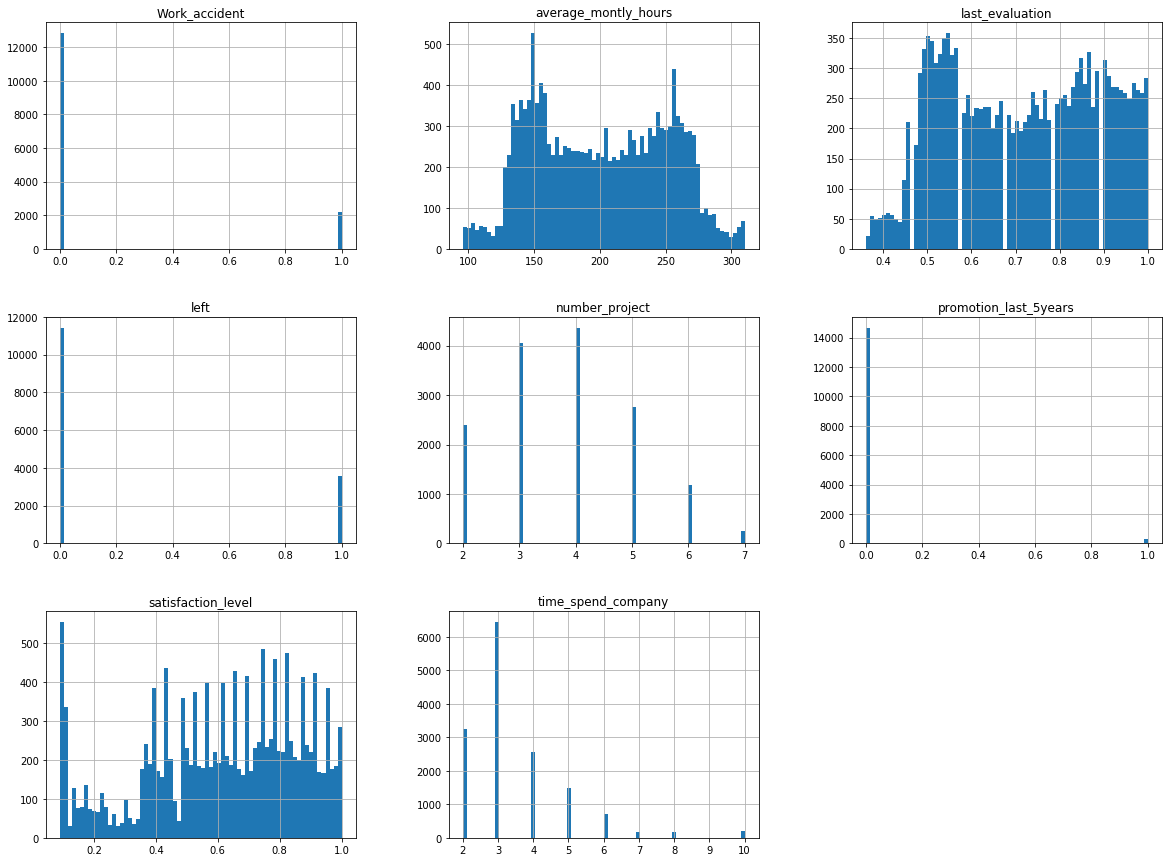

In [7]:
hr_data_full.hist(bins=70, figsize=(20,15))

**Instead of providing actual salary details it was measured as low medium and high.  This scale is done internally with-in a Department of the company and with in Job Designation. So low salary means low in among the peers working on same band and in same department**

In [8]:
print (hr_data_full.salary.unique())
print (hr_data_full.sales.unique())

['low' 'medium' 'high']
['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']


**Below is the distribution of the output class in full dataset. Green bar shows ratio of the examples for which historical attrition was yes and Blue bar shows  examples for which attrition was 'NO. We have around 20% observations of positive class i.e. (attrition=Yes)**'.

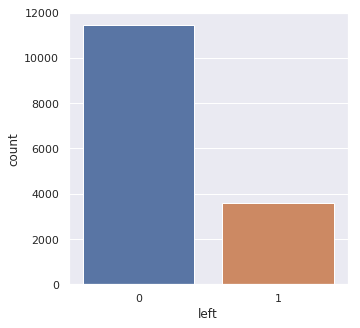

In [9]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x="left",data=hr_data_full)

In [10]:
hr_data_full[hr_data_full.left == 1]['left'].count()/hr_data_full['left'].count()

0.2380825388359224

**Below is the graph that shows level of attrition for different satisfaction level. We can see most of the attrition is in employee with low and medium satisfaction level. However there is a very small attrition  among the employees having higher satisfaction level. Satisfaction scores are provided based upon an internal survey executed by the organization **

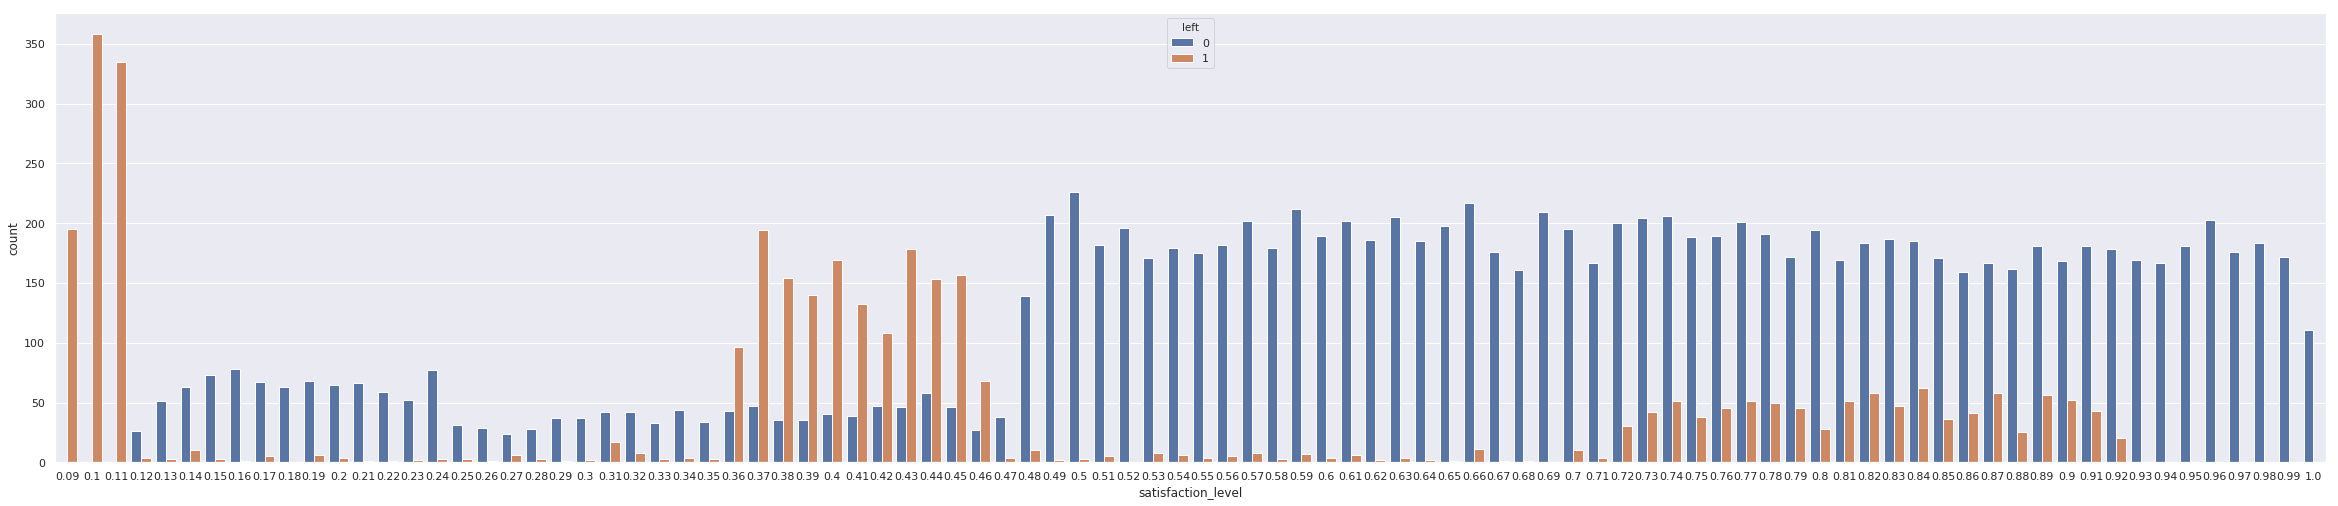

In [12]:
sns.set(rc={'figure.figsize':(40.7,8.27)})

sns.countplot(x="satisfaction_level",data=hr_data_full,hue='left')

*** Below is the graph that shows level of attrition for different salary level. We can see most of the attrition is in employee with low and medium salary level. However there is a very small attrition among the employees having higher higher salaries. ***

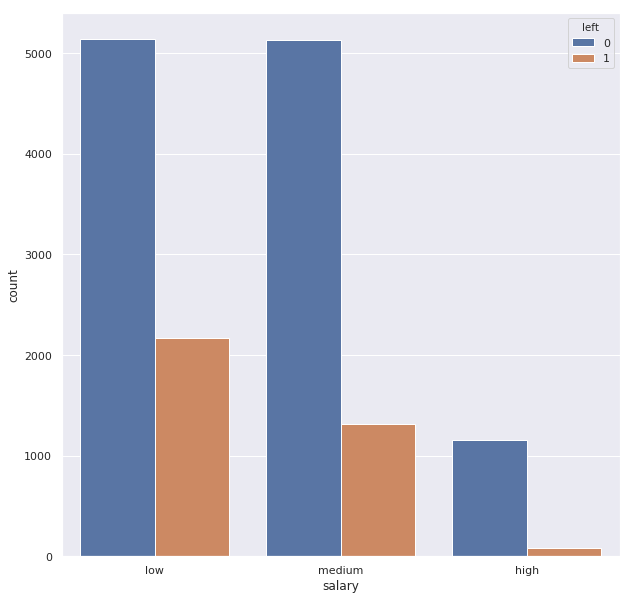

In [11]:
sns.set(rc={'figure.figsize':(10,10)})

sns.countplot(x="salary",data=hr_data_full,hue='left')

***Below graph shows the distribution of attrition on average number of project/task worked by an employee in a year. We can see attrition is high among the people who worked on below average number of projects and employees who have worked on very high number of projects/tasks. This shows there may be an issue with the worklife balance among the employees who have worked on too many projects which might lead to attrition. Similarly employee who had worked on small number of projects have shown higher attrition rate so they may not be satisfied with the work they are doing or they got disengaged because enough work is not available. ***

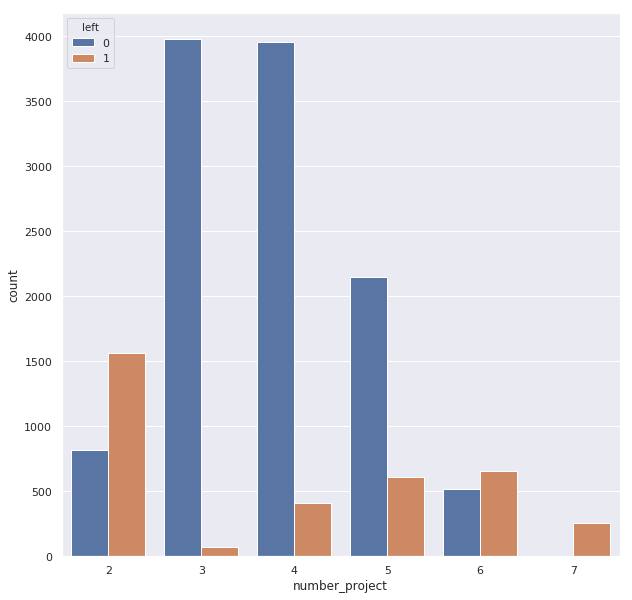

In [14]:
sns.countplot(x="number_project",data=hr_data_full,hue='left')

***Below is the graph for distribution of attrition on last evaluation. We can see high attrition among the people who ever evaluated high. Organization should determine reason for it.***

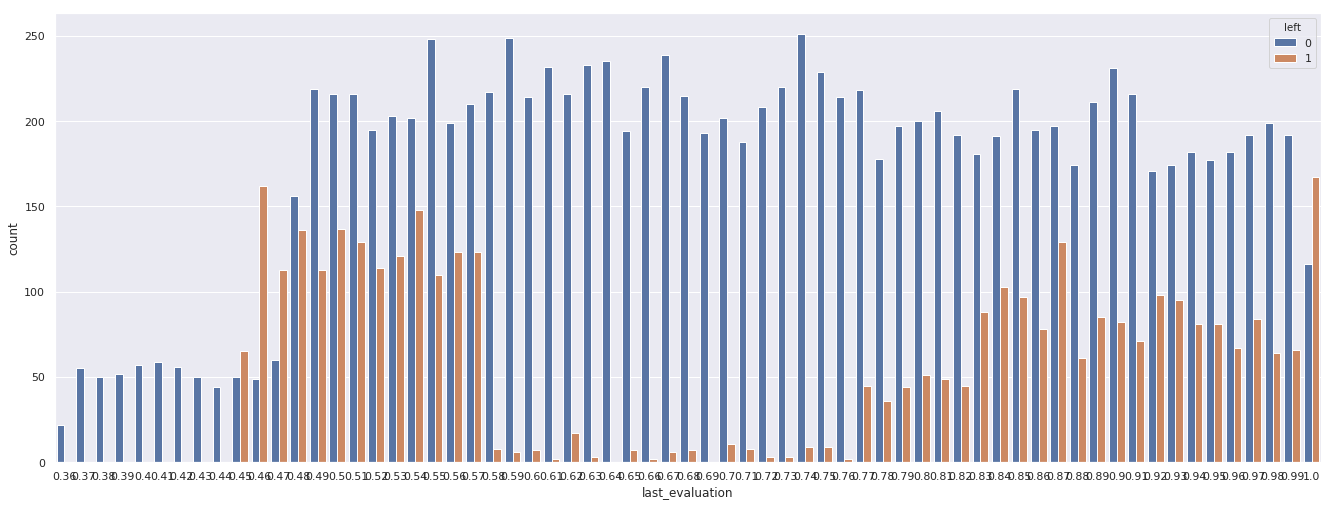

In [15]:
sns.set(rc={'figure.figsize':(22.7,8.27)})
sns.countplot(x="last_evaluation",data=hr_data_full,hue='left')

***Below is the distribution of attrition based upon time spend in company. We can see higher attrition among the people who had 3-5 years of experience. Attrition trend is lower among the people who has < 2 years of expereince and people who had 7+ years of experience.***

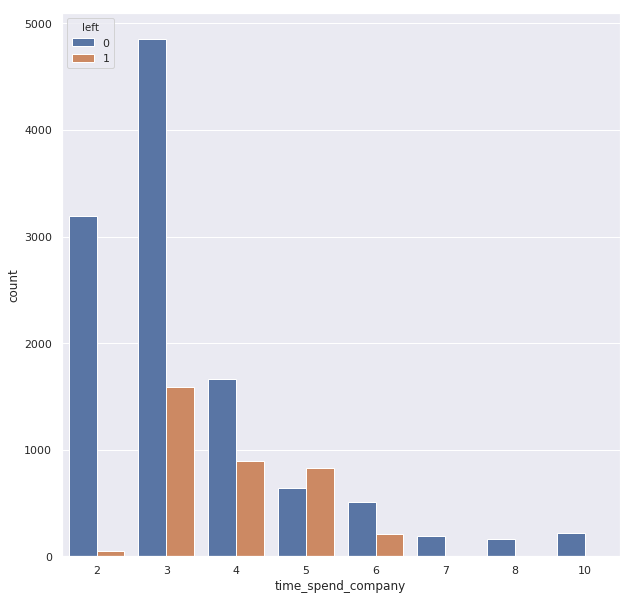

In [13]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(x="time_spend_company",data=hr_data_full,hue='left')

***Below is the distribution of attrition based upon the fact that if person had a recent promotion. There is a higher attrition rate among the people who were not promoted***

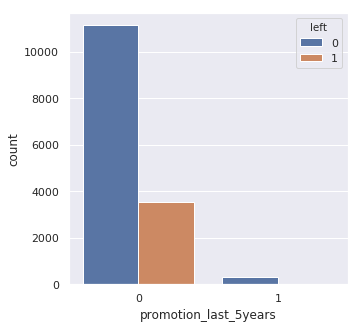

In [17]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x="promotion_last_5years",data=hr_data_full,hue='left')

***Below is the distribution of attrition based for each Department. We can see higer attrition in IT, Technical support and sales. However attrition is very low in Management and R&D.***

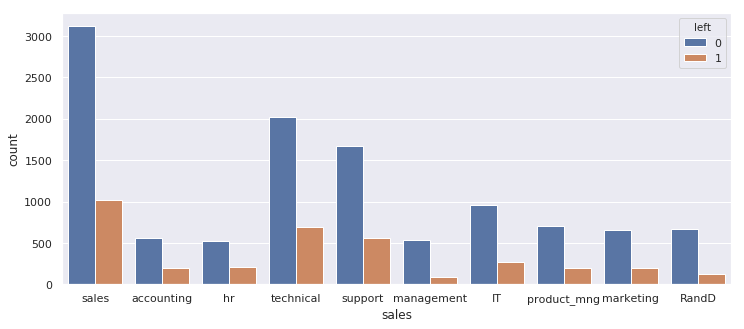

In [16]:
sns.set(rc={'figure.figsize':(12,5)})
sns.countplot(x="sales",data=hr_data_full,hue='left')

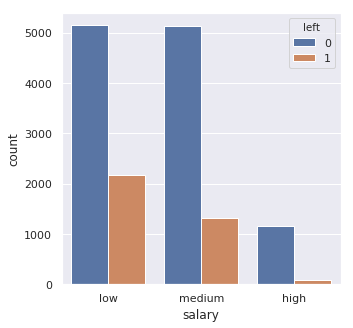

In [18]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x="salary",data=hr_data_full,hue='left')

***Below we are creating Training and Test Split. Entire data is divided into 90% Training Set and 10% Test Set. The entire dataset is first shuffled and then split. To address the class imbalance problem and to have good test set we are using Stratified sampling on number of attrition cases in each Training and Test Set. Stratified sampling will keep proportion of example with attrition 'Yes' and "No" same in training and test set.***

In [0]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(hr_data_full, hr_data_full["left"]):
    hr_data_train = hr_data_full.loc[train_index]
    hr_data_test = hr_data_full.loc[test_index]

***Below cell shows Number of Records in Training Set and Number of Record in Test Set.***

In [21]:
print (hr_data_train.shape)
print (hr_data_test.shape)

(13499, 10)
(1500, 10)


In [22]:
print (type(hr_data_train))
print (type(hr_data_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


***Creating Labels (Attrition = Yes or No) which is our target class. These labels will be used to train machine learning algorithms and during the test time these tables will be used to measure performance of the trained machine learning algorithm.***

In [0]:
hr_data_train_label = hr_data_train["left"].copy()
hr_data_test_label =  hr_data_test["left"].copy()


In [24]:
print (hr_data_train_label.shape)
print (hr_data_test_label.shape)

(13499,)
(1500,)


***As machine learning algorithm should not get the labels of training and test set we need to remove it.***

In [0]:
hr_data_train = hr_data_train.drop("left",axis=1)
hr_data_test = hr_data_test.drop("left",axis=1)

***Summary of Test Set about the various fields***

In [26]:
hr_data_train.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
count,13499.00000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000
mean,0.61276,0.716707,3.806430,201.149567,3.503445,0.144529,0.020890
std,0.24897,0.171250,1.234811,49.969348,1.461173,0.351639,0.143023
min,0.09000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000
25%,0.44000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000
50%,0.64000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000
75%,0.82000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000
max,1.00000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000


In [27]:
hr_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


***There are two categorical variables in our dataset Department and Salary. However there are 7 numeric variables in our dataset. These variables has to be treated differently to prepare the data that can be fed into machine learning algorithm.***

In [0]:
cat_attribute = ['sales','salary']
numeric_attribute = ["satisfaction_level","last_evaluation","number_project","average_montly_hours","time_spend_company","Work_accident","promotion_last_5years"]

In [0]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [0]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],index=X.columns)
        return self
    def transform(self, X, y=None):
        #return X.fillna(self.most_frequent_)
        return X


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

***Below is the pipeline for numeric variable. It undergoes three stages. We first select the numeric variables and then impute the missing values and standardize the values. Standardization of values are required as different variables are measured on different scale. For eg. satisfaction and evaluation was measured between 0-1 to and hours worked are measured from 0-350 hours. ***

In [0]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(numeric_attribute)),
        ("imputer", SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [0]:
import sklearn_pandas as skpanda

***Below is the pipeline for categorical variable. It undergoes three stages. We first select the categorical variables and then impute the missing values. Then we convert the different levels of categorical variables into one Hot encoding.***.

In [0]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(cat_attribute)),
        ("imputer", skpanda.CategoricalImputer()),
        ("cat_encoder",OneHotEncoder(sparse=False,handle_unknown='ignore' )),
        ])

***Below we do the union of the transformed numeric and categorical variables we create one record for each observation.***

In [0]:
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

***Pipeline is executed on both type of variables. We have to apply pipeline on both training set and test set as they need to undergo similar transformation.***

In [0]:
x_train  = preprocess_pipeline.fit_transform(hr_data_train)
x_test =  preprocess_pipeline.transform(hr_data_test)

In [38]:
print (type(x_train))

<class 'numpy.ndarray'>


***creating labels for train and test set.**

In [0]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(hr_data_train_label)
y_test = le.fit_transform(hr_data_test_label)

***Size of final training and test set. Due to One hot encoding number of columns are increased from 10 to 20. One column for each level of categorical variables.**

In [40]:
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)
print (hr_data_train.shape)

(13499, 20)
(1500, 20)
(13499,)
(1500,)
(13499, 9)


***Below is the computation of correlation between different numeric variables. We can see positive correlation between last evaluation and average monthly hours pair. However there is negative correlation between number of project and satisfaction level which may indicate lesser worklife balance.***

In [0]:
correlation_matrix = hr_data_train.corr()

In [0]:
print (correlation_matrix)

                       satisfaction_level  last_evaluation  number_project  \
satisfaction_level               1.000000         0.105310       -0.146906   
last_evaluation                  0.105310         1.000000        0.346520   
number_project                  -0.146906         0.346520        1.000000   
average_montly_hours            -0.021872         0.338556        0.417131   
time_spend_company              -0.099282         0.134387        0.196456   
Work_accident                    0.060839        -0.008767       -0.003130   
promotion_last_5years            0.029235        -0.005600       -0.005627   

                       average_montly_hours  time_spend_company  \
satisfaction_level                -0.021872           -0.099282   
last_evaluation                    0.338556            0.134387   
number_project                     0.417131            0.196456   
average_montly_hours               1.000000            0.127994   
time_spend_company                 0.127

In [0]:
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

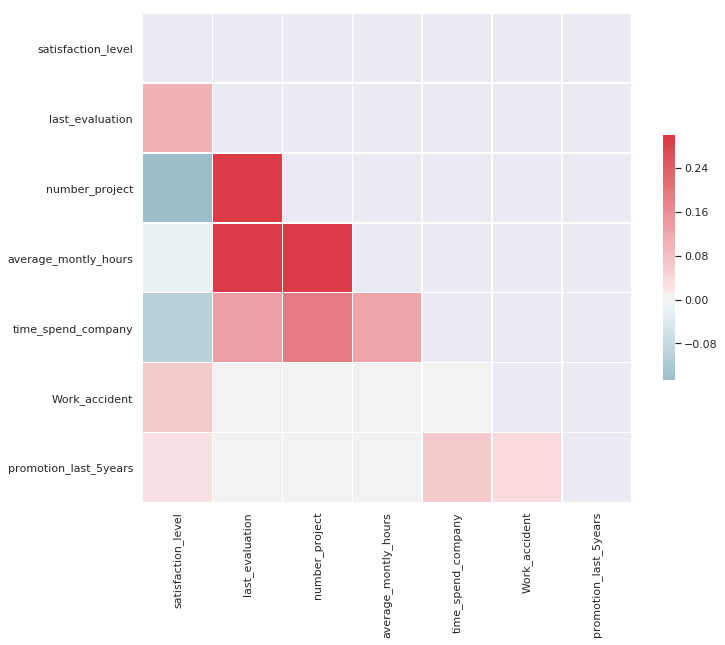

In [43]:
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

***Training a logisitic regression based classifier. ***

In [0]:
logistic_clf = LogisticRegression(random_state=42,class_weight ='balanced',solver='lbfgs',max_iter=1000)

In [45]:
logistic_clf.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [46]:
logistic_regression_scores = cross_val_score(logistic_clf, x_train, y_train, cv=10)
y_train_pred_logistic = cross_val_predict(logistic_clf, x_train, y_train, cv=10)
print (logistic_regression_scores.mean())

0.7583511017930141


In [0]:
cm  = confusion_matrix(y_train, y_train_pred_logistic)

Confusion matrix, without normalization
[[7666 2619]
 [ 643 2571]]


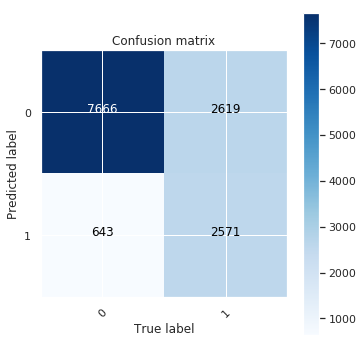

In [51]:
plot_confusion_matrix(cm,[0,1])

In [52]:
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

7666
2619
643
2571


In [0]:
y_test_pred_logistic = logistic_clf.predict(x_test)

In [48]:
cm = confusion_matrix(y_test,y_test_pred_logistic)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

886
257
68
289


Confusion matrix, without normalization
[[886 257]
 [ 68 289]]


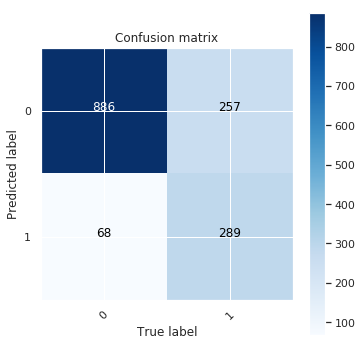

In [49]:
plot_confusion_matrix(cm,[0,1])

In [53]:
classification_report(y_test,y_test_pred_logistic)

'              precision    recall  f1-score   support\n\n           0       0.93      0.78      0.85      1143\n           1       0.53      0.81      0.64       357\n\n   micro avg       0.78      0.78      0.78      1500\n   macro avg       0.73      0.79      0.74      1500\nweighted avg       0.83      0.78      0.80      1500\n'

***Training K Nearest Neighbor***

In [0]:
param_grid = [{"weights":["uniform","distance"],"n_neighbors":[2,3,4,5]}]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=10, verbose=3, n_jobs=-1)
grid_search.fit(x_train, y_train)
print (grid_search.best_params_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [0]:
knn_clf = KNeighborsClassifier(weights='distance',n_neighbors=2)
knn_clf.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='distance')

In [0]:
knn_scores = cross_val_score(knn_clf, x_train, y_train, cv=10)
y_train_pred_knn = cross_val_predict(knn_clf, x_train, y_train, cv=10)
print (knn_scores.mean())

0.9684432766949849


In [0]:
cm  = confusion_matrix(y_train,y_train_pred_knn)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

9984
301
125
3089


Confusion matrix, without normalization
[[9984  301]
 [ 125 3089]]


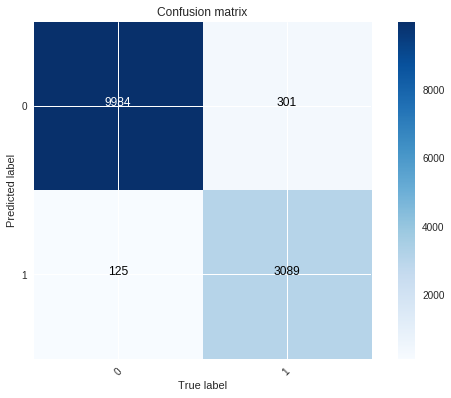

In [0]:
plot_confusion_matrix(cm,[0,1])

In [0]:
y_test_pred_knn = knn_clf.predict(x_test)

In [0]:
cm = confusion_matrix(y_test,y_test_pred_knn)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

1110
33
12
345


Confusion matrix, without normalization
[[1110   33]
 [  12  345]]


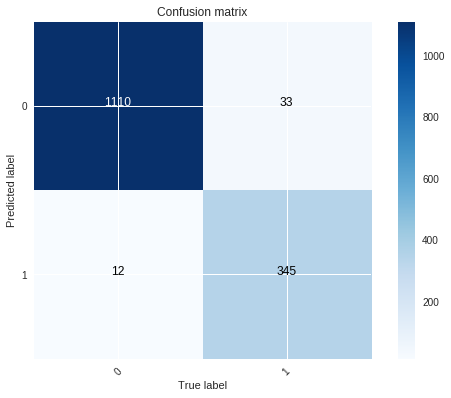

In [0]:
plot_confusion_matrix(cm,[0,1])

In [0]:
classification_report(y_test,y_test_pred_knn)

'              precision    recall  f1-score   support\n\n           0       0.99      0.97      0.98      1143\n           1       0.91      0.97      0.94       357\n\n   micro avg       0.97      0.97      0.97      1500\n   macro avg       0.95      0.97      0.96      1500\nweighted avg       0.97      0.97      0.97      1500\n'

In [0]:
#train SVM Based Model
svm_clf = SVC(gamma="auto",random_state=42)
svm_clf.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
svm_scores = cross_val_score(knn_clf, x_train, y_train, cv=10)
y_train_pred_svm = cross_val_predict(svm_clf, x_train, y_train, cv=10)
print (svm_scores.mean())

0.9684432766949849


In [0]:
y_test_pred_svm = svm_clf.predict(x_test)

In [0]:
cm  = confusion_matrix(y_test,y_test_pred_svm)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

1115
28
37
320


In [0]:
classification_report(y_test,y_test_pred_svm)

'              precision    recall  f1-score   support\n\n           0       0.97      0.98      0.97      1143\n           1       0.92      0.90      0.91       357\n\n   micro avg       0.96      0.96      0.96      1500\n   macro avg       0.94      0.94      0.94      1500\nweighted avg       0.96      0.96      0.96      1500\n'

Confusion matrix, without normalization
[[1115   28]
 [  37  320]]


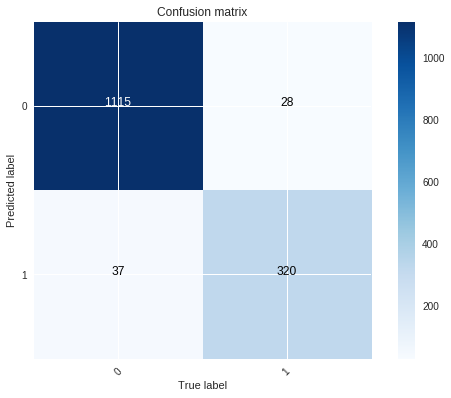

In [0]:
plot_confusion_matrix(cm,[0,1])

In [0]:
xgboost_clf = XGBClassifier(random_state=42)
xgboost_clf.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [0]:
xgboost_scores = cross_val_score(xgboost_clf, x_train, y_train, cv=10)
y_train_pred_xgboost = cross_val_predict(xgboost_clf, x_train, y_train, cv=10)
xgboost_scores.mean()

0.9750372992329845

In [0]:
cm  = confusion_matrix(y_train,y_train_pred_xgboost)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

10183
102
235
2979


Confusion matrix, without normalization
[[10183   102]
 [  235  2979]]


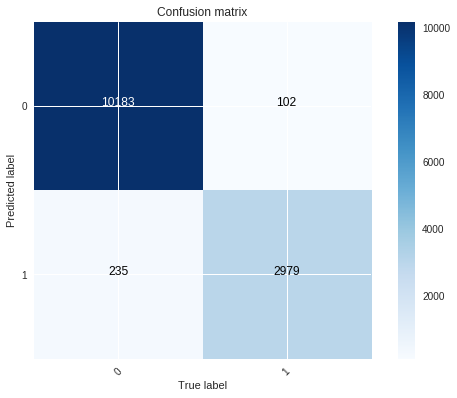

In [0]:
plot_confusion_matrix(cm,[0,1])

In [0]:
y_test_pred_xgboost = xgboost_clf.predict(x_test)

In [0]:
cm  = confusion_matrix(y_test,y_test_pred_xgboost)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

1135
8
25
332


Confusion matrix, without normalization
[[1135    8]
 [  25  332]]


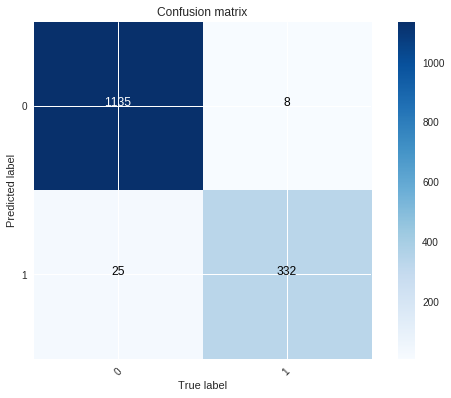

In [0]:
plot_confusion_matrix(cm,[0,1])

In [0]:
x_train.shape

(13499, 20)

In [0]:
# create model
neural_net = Sequential()
neural_net.add(Dense(8, input_dim=20, activation='relu'))
#neural_net.add(Dense(12, activation='relu'))
#neural_net.add(Dense(12, activation='relu'))
#neural_net.add(Dense(12, activation='relu'))
neural_net.add(Dense(12, activation='relu'))
neural_net.add(Dense(1, activation='sigmoid'))
# Compile model
neural_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
neural_net.fit(x_train, y_train, validation_split=0.1,epochs=1500, batch_size=10)

Train on 12149 samples, validate on 1350 samples
Epoch 1/1500
12149/12149 [==============================] - 8s 657us/step - loss: 0.3582 - acc: 0.8425 - val_loss: 0.2090 - val_acc: 0.9378
Epoch 2/1500
12149/12149 [==============================] - 6s 499us/step - loss: 0.1886 - acc: 0.9462 - val_loss: 0.1666 - val_acc: 0.9519
Epoch 3/1500
12149/12149 [==============================] - 6s 490us/step - loss: 0.1629 - acc: 0.9531 - val_loss: 0.1580 - val_acc: 0.9563
Epoch 4/1500
12149/12149 [==============================] - 6s 494us/step - loss: 0.1524 - acc: 0.9556 - val_loss: 0.1513 - val_acc: 0.9585
Epoch 5/1500
12149/12149 [==============================] - 6s 493us/step - loss: 0.1454 - acc: 0.9574 - val_loss: 0.1471 - val_acc: 0.9585
Epoch 6/1500
12149/12149 [==============================] - 6s 495us/step - loss: 0.1415 - acc: 0.9585 - val_loss: 0.1460 - val_acc: 0.9570
Epoch 7/1500
12149/12149 [==============================] - 6s 497us/step - loss: 0.1384 - acc: 0.9591 - val_lo

In [0]:
y_train_pred_neural_net = neural_net.predict_classes(x_train)

In [0]:
cm = confusion_matrix(y_train,y_train_pred_neural_net)

Confusion matrix, without normalization
[[10180   105]
 [  224  2990]]


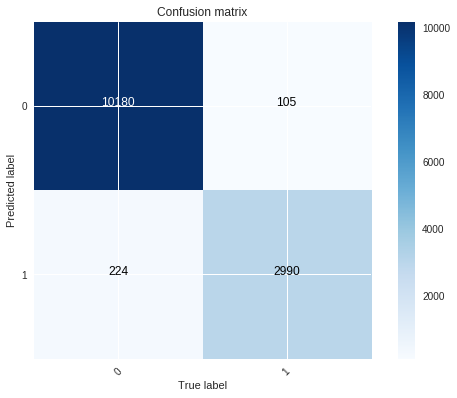

In [0]:
plot_confusion_matrix(cm,[0,1])

In [0]:
classification_report(y_train,y_train_pred_neural_net)

'              precision    recall  f1-score   support\n\n           0       0.98      0.99      0.98     10285\n           1       0.97      0.93      0.95      3214\n\n   micro avg       0.98      0.98      0.98     13499\n   macro avg       0.97      0.96      0.97     13499\nweighted avg       0.98      0.98      0.98     13499\n'

In [0]:
y_test_pred_neural_net = neural_net.predict_classes(x_test)

In [0]:
classification_report(y_test,y_test_pred_neural_net)

'              precision    recall  f1-score   support\n\n           0       0.98      0.98      0.98      1143\n           1       0.93      0.93      0.93       357\n\n   micro avg       0.97      0.97      0.97      1500\n   macro avg       0.95      0.95      0.95      1500\nweighted avg       0.97      0.97      0.97      1500\n'

In [0]:
cm = confusion_matrix(y_test,y_test_pred_neural_net)

Confusion matrix, without normalization
[[1118   25]
 [  25  332]]


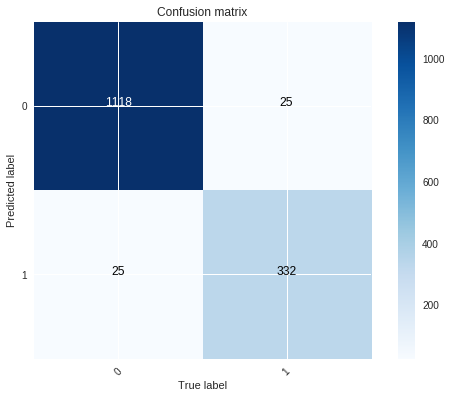

In [0]:
plot_confusion_matrix(cm,[0,1])